In [2]:
# from transformers import AutoImageProcessor, ResNetForImageClassification
# import torch

# processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
# model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
# model = model.resnet
# model.eval()

import torch
from torchvision.models import resnet50, ResNet50_Weights

# Load the weights and the model
# weights = ResNet50_Weights.DEFAULT
# model = resnet50(weights=weights)

import timm
model = timm.create_model('resnet50', pretrained=True)

# This model is much "leaner" than the transformers version
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [3]:
import os
from PIL import Image
import random
from pathlib import Path

import torch, torchvision
import torch.nn as nn
from torchvision import transforms
# from CHIEF.models.ctran import ctranspath
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from PIL import Image, ImageFile, PngImagePlugin
Image.MAX_IMAGE_PIXELS = None 
PngImagePlugin.MAX_TEXT_CHUNK = 100 * 1024 * 1024  # 100MB
PngImagePlugin.MAX_TEXT_MEMORY = 100 * 1024 * 1024 # 100MB

ImageFile.LOAD_TRUNCATED_IMAGES = True


dataDir = Path("/media/toom/New Volume/cuhk_data/HPACG_dataHPACG_split")
train_positive_dir = dataDir / "train/positive"
train_negative_dir = dataDir / "train/negative"

test_positive_dir = dataDir / "test/positive"
test_negative_dir = dataDir / "test/negative"

In [4]:
image = Image.open("./test_img.png").convert("RGB")
trnsfrms_val = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

image = trnsfrms_val(image).unsqueeze(dim=0)
with torch.no_grad():
    patch_feature_emb = model(image) # Extracted features (torch.Tensor) with shape [1,768]
    print(patch_feature_emb.size())

torch.Size([1, 1000])


In [5]:
from os.path import join as j_

train_dataset = torchvision.datasets.ImageFolder(j_(dataDir, 'train'), transform=trnsfrms_val)
test_dataset = torchvision.datasets.ImageFolder(j_(dataDir, 'test'), transform=trnsfrms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=16)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=16) 

In [6]:
from UNI.uni.downstream.eval_patch_features.logistic_regression import LogisticRegression
from UNI.uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from UNI.uni.downstream.eval_patch_features.linear_probe import eval_linear_probe

In [7]:
train_features = extract_patch_features_from_dataloader(model, train_dataloader)
test_features = extract_patch_features_from_dataloader(model, test_dataloader)

100%|██████████| 858/858 [11:42<00:00,  1.22it/s]


In [8]:
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)

from UNI.uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics

linprobe_eval_metrics, linprobe_dump = eval_linear_probe(
    train_feats = train_feats,
    train_labels = train_labels,
    valid_feats = None ,
    valid_labels = None,
    test_feats = test_feats,
    test_labels = test_labels,
    max_iter = 1000,
    verbose= True,
)

print_metrics(linprobe_eval_metrics)

Linear Probe Evaluation: Train shape torch.Size([8005, 1000])
Linear Probe Evaluation: Test shape torch.Size([3432, 1000])
Linear Probe Evaluation (Train Time): Best cost = 20.000
Linear Probe Evaluation (Train Time): Using only train set for evaluation. Train Shape:  torch.Size([8005, 1000])
(Before Training) Loss: 0.693
(After Training) Loss: 0.447
Linear Probe Evaluation (Test Time): Test Shape torch.Size([3432, 1000])
Linear Probe Evaluation: Time taken 1.20
Test lin_acc: 0.783
Test lin_bacc: 0.781
Test lin_kappa: 0.563
Test lin_weighted_f1: 0.783
Test lin_auroc: 0.872


In [9]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_true = linprobe_dump['preds_all']
y_pred = linprobe_dump['targets_all']
cm = confusion_matrix(y_true, y_pred)

labels = ['non-hpacg', 'hpacg']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')

TN, FP, FN, TP = confusion_matrix=cm.ravel()

tpr = TP / (TP + FN) if (TP + FN) > 0 else 0
fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
specificity = TN / (TN + FP) if (FP + TN) > 0 else 0
Balanced_Accuracy = (specificity + tpr) / 2
Precision = TP  / (TP + FP) if (TP + FP) > 0 else 0
Weight_F1 = ((Precision * tpr) / (Precision + tpr))*2

print(f"True Positive Rate (Sensitivity,recall): [{tpr:.3f}]")
print(f"False Positive Rate : [{fpr:.3f}]")
print(f"Specificity : [{specificity:.3f}]")
print(f"Balanced Accuracy : [{Balanced_Accuracy:.3f}]")
print(f"Precision: [{Precision:.3f}]")


ImportError: ConfusionMatrixDisplay.plot requires matplotlib. You can install matplotlib with `pip install matplotlib`

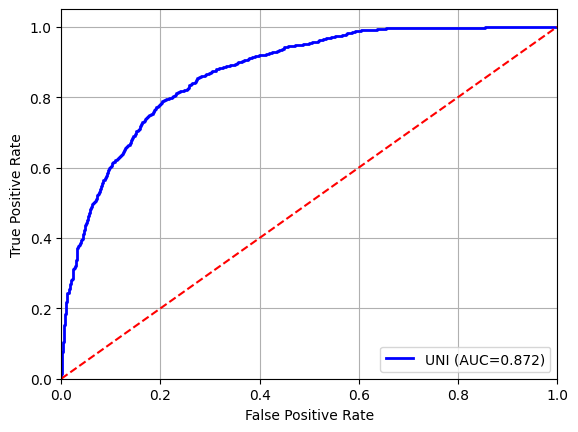

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

true_labels = linprobe_dump['targets_all']
pred_probs = linprobe_dump['probs_all']

fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'UNI (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()